In [10]:
# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [7]:
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (1.0,))
])

In [8]:
from torchvision.datasets import MNIST

download_root = '../080289-main/chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform,
                      train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform,
                     train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform,
                    train=False, download=True)


print(test_dataset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12927312.67it/s]


Extracting ../080289-main/chap07/MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ../080289-main/chap07/MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 346808.48it/s]


Extracting ../080289-main/chap07/MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ../080289-main/chap07/MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 838223.01it/s] 


Extracting ../080289-main/chap07/MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ../080289-main/chap07/MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3452433.63it/s]

Extracting ../080289-main/chap07/MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../080289-main/chap07/MNIST_DATASET/MNIST/raw

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../080289-main/chap07/MNIST_DATASET
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=(1.0,))
           )


In [11]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [12]:
# 변수 값 지정
batch_size=100
n_iters=6000
num_epochs=n_iters/(len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [13]:
# LSTM Cell 네트워크 구축
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)

    def forward(self, x, hidden) :
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 적용
        forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 적용
        cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 적용
        outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 적용

        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))

        return (hy, cy)

In [14]:
# LSTM 네트워크 구성
class LSTMModel(nn.Module) :
   def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim

       self.layer_dim = layer_dim
       self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
       self.fc = nn.Linear(hidden_dim, output_dim)

   def forward(self, x) :
       if torch.cuda.is_available() :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

       if torch.cuda.is_available() :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

       outs = []
       cn =  c0[0,:,:]
       hn = h0[0,:,:]

       for seq in range(x.size(1)) :
           hn, cn = self.lstm(x[:, seq, :], (hn, cn))
           outs.append(hn)

       out = outs[-1].squeeze()
       out = self.fc(out)
       return out

In [15]:
# 옵티마이저 및 손실함수 정의
input_dim=28
hidden_dim=128
layer_dim=1
output_dim=18

model =  LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available() :
   model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate =0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
seq_dim=28
loss_list = []
iter = 0
for epoch in range(num_epochs) :
   for i, (images ,labels) in enumerate(train_loader) :
       if torch.cuda.is_available() :
           images = Variable(images.view(-1, seq_dim, input_dim).cuda())
           labels = Variable(labels.cuda())

       else :
           images = Variable(images.view(-1, seq_dim, input_dim))
           labels = Variable(labels)

       optimizer.zero_grad()
       outputs = model(images)
       loss = criterion(outputs, labels)

       if torch.cuda.is_available() :
           loss.cuda()

       loss.backward()
       optimizer.step()
       loss_list.append(loss.item())
       iter += 1


       if iter % 500 == 0 :
           correct = 0
           total = 0

           for images, labels in valid_loader :

               if torch.cuda.is_available() :
                   images = Variable(images.view(-1, seq_dim, input_dim).cuda())
               else :
                   images = Variable(images.view(-1, seq_dim, input_dim))

               outputs = model(images)
               _, predicted = torch.max(outputs.data, 1)

               total += labels.size(0)
               if torch.cuda.is_available() :
                   correct += (predicted.cpu() == labels.cpu()).sum()

               else :
                   correct += (predicted == labels).sum()

           accuracy = 100 * correct / total
           print(f'Iteration : {iter} Loss : {loss.item()} Accuracy : {accuracy}')

Iteration : 500 Loss : 2.1343958377838135 Accuracy : 28.09000015258789
Iteration : 1000 Loss : 0.760982096195221 Accuracy : 78.83999633789062
Iteration : 1500 Loss : 0.3086998462677002 Accuracy : 90.7300033569336
Iteration : 2000 Loss : 0.09612470865249634 Accuracy : 93.55999755859375
Iteration : 2500 Loss : 0.06641891598701477 Accuracy : 95.20999908447266
Iteration : 3000 Loss : 0.06276842206716537 Accuracy : 96.19000244140625
Iteration : 3500 Loss : 0.12372501194477081 Accuracy : 95.26000213623047
Iteration : 4000 Loss : 0.1309157758951187 Accuracy : 97.04000091552734
Iteration : 4500 Loss : 0.10493671894073486 Accuracy : 97.25
Iteration : 5000 Loss : 0.06193013861775398 Accuracy : 97.31999969482422
Iteration : 5500 Loss : 0.008130055852234364 Accuracy : 97.62000274658203
Iteration : 6000 Loss : 0.1118694543838501 Accuracy : 97.43000030517578
Iteration : 6500 Loss : 0.029249949380755424 Accuracy : 97.52999877929688
Iteration : 7000 Loss : 0.06277099251747131 Accuracy : 97.98000335693

In [21]:
def evaluate(model, val_iter) :
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter :
        if torch.cuda.is_available() :
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = labels.cuda() #원래 없없음
        else :
            images = Variable(images.view(-1, seq_dim, input_dim).to(device))

        logit = model(images)  #.to(device) 였음
        loss = F.cross_entropy(logit, labels, reduction='sum')
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [22]:
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss : {test_loss:5.2f} | Test Accuracy : {test_acc:5.2f}')

Test Loss :  0.06 | Test Accuracy :  0.98


##LSTM 계층 구현

###스타벅스 주가 데이터 활용

In [24]:
ls

sample_data/  SBUX.csv  shakespeare.txt


In [25]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('./SBUX.csv')
print(data.dtypes)
print(data)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
           Date        Open        High         Low       Close   Adj Close  \
0    2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752   
1    2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032   
2    2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046   
3    2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941   
4    2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288   
..          ...         ...         ...         ...         ...         ...   
248  2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787   
249  2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918   
250  2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554   
251  2020-12-09  101.940002  102.209999  100.0999

In [26]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [27]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


In [28]:
# 데이터셋 형태, 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


In [29]:
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [30]:
# 변수값 설정
num_epochs = 1000
lr = 0.0001

input_size=5
hidden_size=2
num_layers=1

num_classes=1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.07928
Epoch : 100, loss : 0.03236
Epoch : 200, loss : 0.03232
Epoch : 300, loss : 0.03229
Epoch : 400, loss : 0.03233
Epoch : 500, loss : 0.03224
Epoch : 600, loss : 0.03220
Epoch : 700, loss : 0.03215
Epoch : 800, loss : 0.03211
Epoch : 900, loss : 0.03202


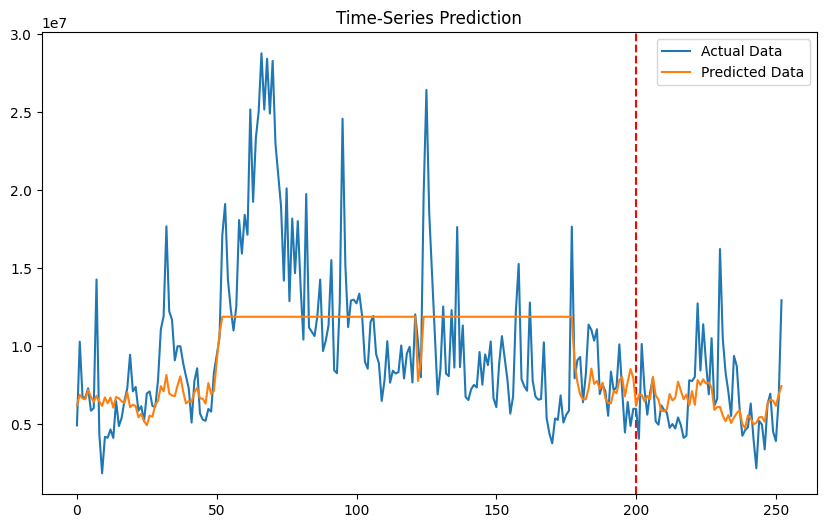

In [32]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()